<a href="https://colab.research.google.com/github/jbiancamano/Projects/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Justin Biancamano & Partrick Dowd
## Assignment 1 (k-NN Classification)
### CSC/DSP 461
### October 13, 2021


In [ ]:
# preamble to be able to run notebooks in Colab
from google.colab import drive
import sys

# mount the drive
drive.mount('/content/drive')

# useful folders
notes_home = '/content/drive/Shared drives/CSC 461'
    
# insert the notes folder into the path so we can include assets modules etc
sys.path.insert(1,notes_home) 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from scipy.stats import mode
from sklearn.metrics import accuracy_score

# model evaluation routines
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import DistanceMetric

import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.neighbors import BallTree
from sklearn.neighbors import DistanceMetric
import seaborn as sns

# **Dataset**
## The dataset you will use for your experiments is the Wine Quality Data Set available at the UCI ML Repository. You may want to inspect the features and decide to preprocess (e.g. normalization) before applying machine learning. The repository provides two datasets, related to red and white vinho verde wine samples, from the north of Portugal, The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009]).
### For this assignment you will only work with one of both datasets. Pick either red or white data.

In [ ]:
# We will be using the red wine dataset
# Get data
red = pd.read_csv("/content/drive/Shared drives/CSC 461/winequality-red.csv")
red.head(n=10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15,59,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15,21,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9,18,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17,102,0.9978,3.35,0.80,10.5,5


In [ ]:
red.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.875547,46.468418,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460434,32.895920,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


# **Your Work**
##[30 pts] Correct implementations of two k-nn versions. You can use a single Python class, taking different parameters to indicate the version in the constructor method. Feel free to use the notebook provided in class as starter code.

## *  **vanilla**: this is the method presented in class

## * **ball**: same principle as vanilla, but instead of using the majority of *k* nearest neighbors, use the majority vote of all examples *X* such that 
## distance(*X'*, *X*) <= *e*. You can treat *e* as a hyperparameter to this method, instead of *k*

## [50 pts] Perform hyperparameter selection using the **train-valid-test splits** as shown in class. It is important to note, that the test set cannot be used during the hyperparameter selection process, use the validation set instead. Experiment with at least 10 different values for  and , and the following *distance* functions: **euclidean**, **cityblock**, **cosine**, **chebyshev**, **sqeuclidean** (this list can be different if you go for extra points). If you are using the **cdist** function, refer to the documentation.

## *  find the best *k* and distance function for **vanilla**
## * find the best *e* and distance fucntion for **ball**

## [20 points] After selecting the best hyperparameters, report the accuracy of your best classifier on the test set. At this point, you can actually merge the training and validation set to estimate the test set accuracy.

In [ ]:
X=red.values[:,0:11]
y=red.values[:,11]

# Split data into 70% train and 30% test subsets (15% val and 15% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state = 28)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state = 28)
print(X_train.shape, X_valid.shape, X_test.shape)
print(Y_train.shape, Y_valid.shape, Y_test.shape)


(1119, 11) (240, 11) (240, 11)
(1119,) (240,) (240,)


In [ ]:
class KNN:

    def __init__(self, k = 3, metric = 'euclidean', E=2.5):
        self.k = k
        self.metric = metric
        self.E = E

    def fit(self, data, target):
        self.x = data
        self.y = target

    def predict_vanilla(self, tedata):
        pred = np.zeros((tedata.shape[0], 1))
        # columns store all distances for each test datapoint (before transpose)
        distances = cdist(self.x, tedata, metric=self.metric).T
        for i in range(distances.shape[0]):
            top_k = self.y[np.argsort(distances[i])[:self.k]].tolist()
            pred[i] = mode(top_k, axis=None).mode[0]
        return pred.astype(int)

    def predict_ball(self, tedata):
        pred = np.zeros((tedata.shape[0], 1))
        distances = cdist(self.x, tedata, metric=self.metric).T
        for i in range(distances.shape[0]):
          dist=[j for j in np.argsort(distances[i])[:-1] if j <= int(self.E)]
          cut_off=len(dist)
          majority_vote = self.y[np.argsort(distances[i])[:cut_off]].tolist()          
          pred[i] = mode(majority_vote, axis=None).mode[0]
        return pred.astype(int)


In [ ]:
clf = KNN()
clf.fit(X_train, Y_train)
predict_train = clf.predict_ball(X_train)

In [ ]:
K = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
E = [0.1 , 0.5, 0.8 , 1 , 2 , 5 , 7 , 10 , 15 ,20 ]
dist = [ 'braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 
        'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'jensenshannon', 
        'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto',
        'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule']

In [ ]:
best_loss = 5555
best_p = 5555
distance=[]
k=[]
acc_train=[]
acc_valid=[]

for x in K:
  for d in dist:
    clf = KNN(k=x, metric=d)
    clf.fit(X_train, Y_train)

    predict_train = clf.predict_vanilla(X_train)
    predict_valid = clf.predict_vanilla(X_valid)

    loss_0_1_valid = np.mean(predict_valid != Y_valid)
    loss_0_1_train = np.mean(predict_train != Y_train)
    distance.append(d)
    k.append(x)
    accuracy_t=np.sum(Y_train == predict_train.flatten())/len(Y_train)
    accuracy_v=np.sum(Y_valid == predict_valid.flatten())/len(Y_valid)
    acc_train.append(accuracy_t)
    acc_valid.append(accuracy_v)

    if loss_0_1_valid < best_loss:
        best_loss = loss_0_1_valid
        best_p = x

    print('K: {}    dist:{}     training loss: {:.4f}     validation loss: {:.4f}'.format(x, d, loss_0_1_train, loss_0_1_valid))
data={'K':k, 'Distance':distance, 'acc_valid':acc_valid, 'acc_train':acc_train}
# data=np.array(data)
vanilla_df=pd.DataFrame(data=data)

K: 1    dist:braycurtis     training loss: 0.6398     validation loss: 0.6428
K: 1    dist:canberra     training loss: 0.6398     validation loss: 0.6458
K: 1    dist:chebyshev     training loss: 0.6398     validation loss: 0.6372
K: 1    dist:cityblock     training loss: 0.6398     validation loss: 0.6438
K: 1    dist:correlation     training loss: 0.6398     validation loss: 0.6551
K: 1    dist:cosine     training loss: 0.6398     validation loss: 0.6514
K: 1    dist:dice     training loss: 0.8516     validation loss: 0.8475
K: 1    dist:euclidean     training loss: 0.6398     validation loss: 0.6356
K: 1    dist:hamming     training loss: 0.6398     validation loss: 0.6417
K: 1    dist:jaccard     training loss: 0.6398     validation loss: 0.6416
K: 1    dist:jensenshannon     training loss: 0.6398     validation loss: 0.6469
K: 1    dist:kulsinski     training loss: 0.8516     validation loss: 0.8475
K: 1    dist:mahalanobis     training loss: 0.6398     validation loss: 0.6550
K: 

In [ ]:
vanilla_df

,K,Distance,acc_valid,acc_train
0,1,braycurtis,0.541667,1.000000
1,1,canberra,0.591667,1.000000
2,1,chebyshev,0.541667,1.000000
3,1,cityblock,0.537500,1.000000
4,1,correlation,0.520833,1.000000
...,...,...,...,...
215,10,seuclidean,0.545833,0.663986
216,10,sokalmichener,0.420833,0.430742
217,10,sokalsneath,0.420833,0.430742
218,10,sqeuclidean,0.500000,0.565684


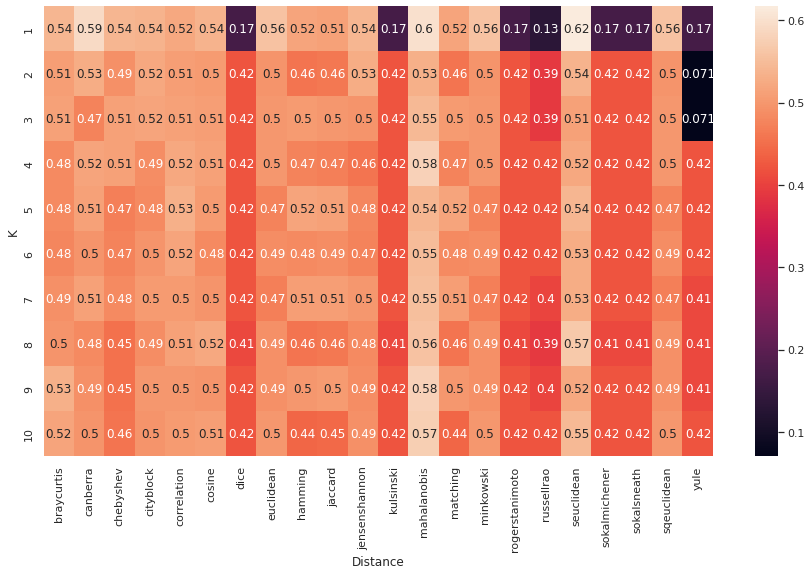

In [ ]:
sns.set(rc={'figure.figsize':(15,8.27)})
vanilla_valid = vanilla_df.drop(axis=1, labels=['acc_train'])
vanilla_valid = vanilla_valid.pivot('K', 'Distance', 'acc_valid') 
sns.heatmap(data=vanilla_valid, annot=True)

Looking at the vanilla method on the valid data we can see there is not much difference in accuracy between k=4, 5, 6, 7, 8, 9, and 10. each of them have about the same accuracy for each different distance fucntion. The odd one out is K=1 which has 7 distances of accuracy less than 20%. K=2 and K = 3 are the only parameters who has a dsitance whose accuracy is even less than 10%. Based on this plot we can determine that the distance metric "yule" will not be used in the best model for the vanilla method

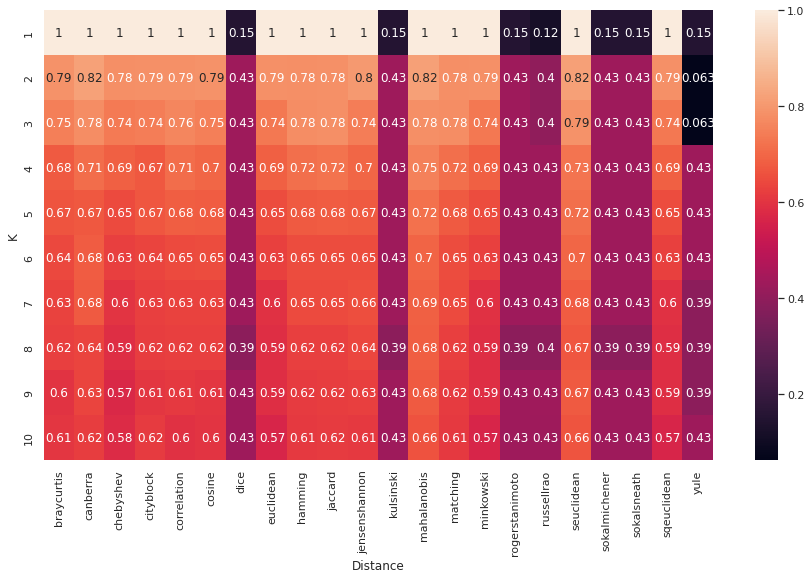

In [ ]:
sns.set(rc={'figure.figsize':(15,8.27)})
vanilla_train = vanilla_df.drop(axis=1, labels=['acc_valid'])
vanilla_train = vanilla_train.pivot('K', 'Distance', 'acc_train') 
sns.heatmap(data=vanilla_train, annot=True)

This char also shows we will not use "yule" for the vanilla model. It also shows that we mwill not be using "dice", "kulsinski", "rogerstanimoto", "russellrao", "sokalmichener", and "sokalsneath". When K=1 we do get an accuracy of 100% for some of the distances and less than 20% for the distances which we already determined would not be used. Considering the "seuclidean" has the lightest color column, which means highest accuracy, most likely we will use this distance for the vanilla method. 

In [ ]:
# Report the accuracy of the best k parameter on the test data
best_vanilla = KNN(k=1, metric='seuclidean')
best_vanilla.fit(X_train,Y_train)
predict_test_vanilla = best_vanilla.predict_vanilla(X_test)
loss_0_1_vanilla = np.mean(predict_test_vanilla != Y_test)
acc_vanilla = accuracy_score(predict_test_vanilla, Y_test)
print('K: {}     test loss: {:.4f}       accuracy: {:.4f}'.format(1, loss_0_1_vanilla, acc_vanilla))

K: 1     test loss: 0.6321       accuracy: 0.6250


In [ ]:
K = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
E = [0.1 , 0.5, 0.8 , 1 , 2 , 5 , 7 , 10 , 15 ,20 ]
dist = [ 'braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 
        'cosine', 'dice', 'euclidean', 'jensenshannon', 
        'kulsinski', 'mahalanobis', 'minkowski', 'rogerstanimoto',
        'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule']

In [ ]:
best_loss = 5555
best_p = 5555
distance=[]
k=[]
acc_train=[]
acc_valid=[]

for x in E:
  for d in dist:
    clf = KNN(E=x, metric=d)
    clf.fit(X_train, Y_train)

    predict_train = clf.predict_ball(X_train)
    predict_valid = clf.predict_ball(X_valid)

    loss_0_1_valid = np.mean(predict_valid != Y_valid)
    loss_0_1_train = np.mean(predict_train != Y_train)
    distance.append(d)
    k.append(x)
    accuracy_t=np.sum(Y_train == predict_train.flatten())/len(Y_train)
    accuracy_v=np.sum(Y_valid == predict_valid.flatten())/len(Y_valid)
    acc_train.append(accuracy_t)
    acc_valid.append(accuracy_v)


    if loss_0_1_valid < best_loss:
        best_loss = loss_0_1_valid
        best_x = x

    print('E: {}    dist: {}     training loss: {:.4f}     validation loss: {:.4f}'.format(x, d, loss_0_1_train, loss_0_1_valid))
data={'K':k, 'Distance':distance, 'acc_valid':acc_valid, 'acc_train':acc_train}
ball_df=pd.DataFrame(data=data)

E: 0.1    dist: braycurtis     training loss: 0.6398     validation loss: 0.6428
E: 0.1    dist: canberra     training loss: 0.6398     validation loss: 0.6458
E: 0.1    dist: chebyshev     training loss: 0.6398     validation loss: 0.6372
E: 0.1    dist: cityblock     training loss: 0.6398     validation loss: 0.6438
E: 0.1    dist: correlation     training loss: 0.6398     validation loss: 0.6551
E: 0.1    dist: cosine     training loss: 0.6398     validation loss: 0.6514
E: 0.1    dist: dice     training loss: 0.8516     validation loss: 0.8475
E: 0.1    dist: euclidean     training loss: 0.6398     validation loss: 0.6356
E: 0.1    dist: jensenshannon     training loss: 0.6398     validation loss: 0.6469
E: 0.1    dist: kulsinski     training loss: 0.8516     validation loss: 0.8475
E: 0.1    dist: mahalanobis     training loss: 0.6398     validation loss: 0.6550
E: 0.1    dist: minkowski     training loss: 0.6398     validation loss: 0.6356
E: 0.1    dist: rogerstanimoto     train

In [ ]:
ball_df

,K,Distance,acc_valid,acc_train
0,0.1,braycurtis,0.541667,1.000000
1,0.1,canberra,0.591667,1.000000
2,0.1,chebyshev,0.541667,1.000000
3,0.1,cityblock,0.537500,1.000000
4,0.1,correlation,0.520833,1.000000
...,...,...,...,...
185,20.0,seuclidean,0.579167,0.620197
186,20.0,sokalmichener,0.408333,0.394996
187,20.0,sokalsneath,0.408333,0.394996
188,20.0,sqeuclidean,0.466667,0.559428


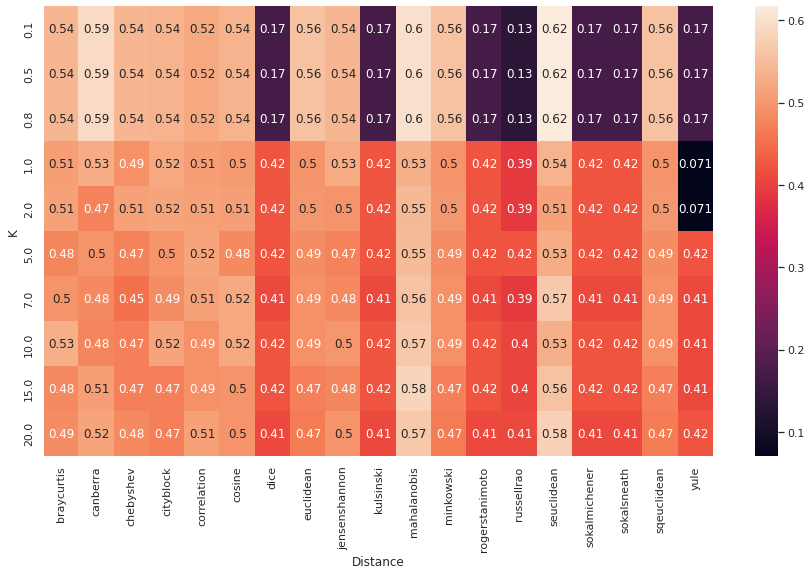

In [ ]:
sns.set(rc={'figure.figsize':(15,8.27)})
ball_valid = ball_df.drop(axis=1, labels=['acc_train'])
ball_valid = ball_valid.pivot('K', 'Distance', 'acc_valid') 
sns.heatmap(data=ball_valid, annot=True)

As is true with the vanilla method, the best ball model will also not use "dice", "kulsinski", "rogerstanimoto", "russellrao", "sokalmichener", "sokalsneath", and "yule". epsilon = 0.1, 0.5, and 0.8 have the highest accuracy when paired with the right distance. This suggests that one of these 3 will be the best for the epsilon parameter in the ball method.

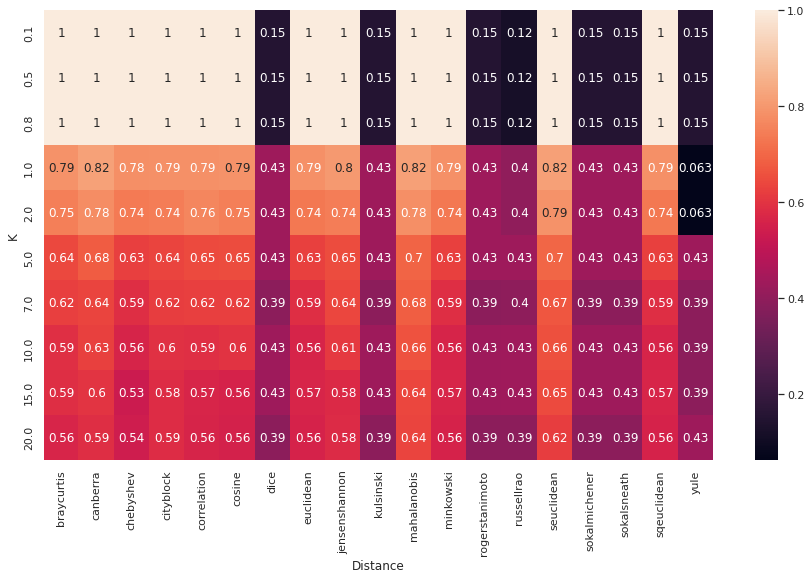

In [ ]:
sns.set(rc={'figure.figsize':(15,8.27)})
ball_train = ball_df.drop(axis=1, labels=['acc_valid'])
ball_train = ball_train.pivot('K', 'Distance', 'acc_train') 
sns.heatmap(data=ball_train, annot=True)

Epsilon = 0.1, 0.5, and 0.8 having accuracies of 1 with certain distances further proves the earlier point that one of these will be the best parameter. Considering that from the vanilla method, it was determined from the chart that seuclidan was the best distance metric, it probably will be as well for the ball method.

In [ ]:
# Report the accuracy of the best k parameter on the test data
best_ball = KNN(E=.01, metric='seuclidean')
best_ball.fit(X_train,Y_train)
predict_test_ball = best_ball.predict_ball(X_test)
loss_0_1_ball = np.mean(predict_test_ball != Y_test)
acc_ball = accuracy_score(predict_test_ball, Y_test)
print('K: {}     test loss: {:.4f}       accuracy: {:.4f}'.format(0.01, loss_0_1_ball, acc_ball))

K: 0.01     test loss: 0.6321       accuracy: 0.6250


In [ ]:
X_V_T=np.concatenate((X_train,X_valid), axis=0)
Y_V_T=np.concatenate((Y_train,Y_valid), axis=0)

In [ ]:
# This is the test for the best ball hyperparameters with concatinated training and validation data
best_ball_merge = KNN(E=.01, metric='seuclidean')
best_ball_merge.fit(X_V_T, Y_V_T)
predict_test_ball_merge = best_ball_merge.predict_ball(X_test)
loss_0_1_ball_merge = np.mean(predict_test_ball_merge != Y_test)
acc_ball_merge = accuracy_score(predict_test_ball_merge, Y_test)
print('E: {}     test loss: {:.4f}       accuracy: {:.4f}'.format(.01, loss_0_1_ball_merge, acc_ball_merge))

E: 0.01     test loss: 0.6379       accuracy: 0.6500


In [ ]:
# This is the test for the best vanilla hyperparameters with concatinated training and validation data
best_vanilla_merge = KNN(k=1, metric='seuclidean')
best_vanilla_merge.fit(X_V_T, Y_V_T)
predict_test_vanilla_merge = best_vanilla_merge.predict_vanilla(X_test)
loss_0_1_test_vanilla_merge = np.mean(predict_test_vanilla_merge != Y_test)
acc_vanilla_merge = accuracy_score(predict_test_vanilla_merge, Y_test)
print('test loss: {:.4f}    accuracy: {:.4f}'.format(loss_0_1_test_vanilla_merge, acc_vanilla_merge))

test loss: 0.6379    accuracy: 0.6500


# **Analysis**

In [ ]:
print("Vanilla Method:")
print("---------------------------------------------------")
print("Using training to predict testing:")
print('Best K: {}     test loss: {:.4f}       accuracy: {:.4f}'.format(1, loss_0_1_vanilla, acc_vanilla))
print("Using training and validation to predict testing:")
print('Best K: {}     test loss: {:.4f}       accuracy: {:.4f}'.format(1, loss_0_1_test_vanilla_merge, acc_vanilla_merge))
print("---------------------------------------------------")
print("Ball Method:")
print("---------------------------------------------------")
print("Using training to predict testing:")
print('E: {}     test loss: {:.4f}       accuracy: {:.4f}'.format(0.01, loss_0_1_ball, acc_ball))
print("Using training and validation to predict testing:")
print('E: {}     test loss: {:.4f}       accuracy: {:.4f}'.format(0.01, loss_0_1_ball_merge, acc_ball_merge))

Vanilla Method:
---------------------------------------------------
Using training to predict testing:
Best K: 1     test loss: 0.6257       accuracy: 0.5708
Using training and validation to predict testing:
Best K: 1     test loss: 0.6379       accuracy: 0.6500
---------------------------------------------------
Ball Method:
---------------------------------------------------
Using training to predict testing:
E: 0.01     test loss: 0.6321       accuracy: 0.6250
Using training and validation to predict testing:
E: 0.01     test loss: 0.6379       accuracy: 0.6500


For both methods vanilla and ball we can see that the best distance metric is seuclidian. Some other distances with the best parameter did have similar training and validation loss but it is better and less time consuming to use the same distance metric for both methods. For the vanilla method the best hyperparameter is when K = 1. This means our model is most accurate when we chose the nearest neighbor. It offers the highest accuracy but doest not have the best training, validation, or test loss. The best trainging and validation loss for the vanilla method is about 0.58 but loss is how bad the model predicted a single example. Overall the accuracy of the best parameter is significantly higher than that where the loss was significantly lower. It is interesting to note that when we combine the traing and validation data to predict the test data our accuracy improves by about 8% and our loss is only worse by about 1.5% Considering we are trying to minimize training loss and have that loss close to our test loss we can safely say this is the best k and distance. For the ball method the best parameter is epsilon = 0.01. This gives us the best of everything we are concerned about: accuracy, training loss, validation loss, and test loss. The best loss provided by our best parameter is about 0.64 and our accuracy is about 62.5%. When we combine the training and validation set to predict the test we only gain about a 0.5% test loss and about a 3% increase in accuracy. For both methods vanilla and ball when we combine the train adn valid data our accuracy has gone up by at least 2% and the test loss has increased at most about 1.5% Therefore we can conclude that to predict wine quality using KNN the best parameters are number of nearest neighbors (K) = 1, epsilon = 0.01, and metric = seuclidean. It is interesting to note though that our best numerical parameter are the lowest values for the ones we tested as well as the accuracy and testing loss for when we combined trainging and validation are the same with an accuracy of 65% and a test loss of 63.79%. It is good that our accuracy is higher than our test loss but it is not ideal that the two values are so close.

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.neighbors import BallTree
from sklearn.neighbors import DistanceMetric

[[ 0  0  0  1  0  0]
 [ 0  0  2  3  0  0]
 [ 0  0 73 23  2  0]
 [ 0  0 36 56  6  0]
 [ 0  0  6 19  7  0]
 [ 0  0  2  4  0  0]]


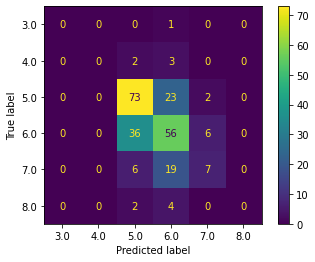

In [ ]:
disp = metrics.plot_confusion_matrix(best_clf, X_test, Y_test)
print(disp.confusion_matrix)
plt.show()